---
layout: post
title:  "Visualising Patient Contributions for the CCCC"
desc: "A visual thank you to our contributing sites"
date: ###DATE
categories: [tutorial]
tags: [plotting]
loc: ###LOC
permalink: /tutorials/cccc_enrolment
math: true
---

The COVID-19 Critical Care Consortium is an international collaboration of hundreds of hospital sites from dozens of countries around the world. Our sites have been slowly but steadily gathering data for critical cases of COVID-19 since earlier in the year, and we thought it would be good to show just how international the collaboration is.

To that end, in my role as one of the technical leads (responsible for the data pipeline and ingestion), I created out a simple (and no-risk) data product simply containing a list of our participant sites, and how many patients they have enrolled in our study at a given date. The details for those patients are - of course - not contained in this data product in any way.

This is what we're going to be making.

In [44]:
from IPython.display import Video
import warnings
warnings.filterwarnings('ignore')
Video("cccc_enrolment/contributions.mp4")

# Basic Dataset Prep

So let's start things up, and load in the enrolment data.

In [45]:
import pandas as pd
import numpy as np
data = pd.read_csv("cccc_enrolment/enrolment_site.csv", parse_dates=[0], index_col=0)
data = data.fillna(0).astype(int)
data.iloc[-5:, :5]

,00543-Medical University of Vienna,00544-Lancaster General Health,00546-Penn Medicine,00547-Oklahoma Heart Institute,00548-UH Cleveland Hospital
date_enrolment,,,,,
2020-07-30,7,39,42,2,20
2020-07-31,7,39,42,2,20
2020-08-01,7,39,42,2,20
2020-08-02,7,39,42,2,20
2020-08-03,7,39,42,2,20


Great, so you can see we have the vetical axis representing the date, and each site is a column, with its numeric identifier first. Lets remove those IDs, because they are useful in a database, but not for us.

In [46]:
sites = [c.split("-", 1)[1] for c in data.columns]
print(sites[60:70])

['Fukuoka University', 'Yokohama City University Medical Center', 'Nagoya University Hospital', 'PICU Saiful Anwar Hospital', 'Adult ICU Saiful Anwar Hospital', 'KourituTouseiHospital', 'HokkaidoUniversityHospital', 'ChibaUniversityHospital', 'UniversityofAlabamaatBirminghamHospital', 'UniversityofFlorida']


Looking good so far. However, I know that some of the sites have - for some reason - had all whitespace removed. So lets write a small parser to go from CamelCase to normal words.

In [47]:
# Some of the sites are missing spaces for some reason
def fix_site(site):
    if " " not in site:
        # Dont fix a sitename which is an acryonym
        if site != site.upper():
            site = ''.join(map(lambda x: x if x.islower() else " " + x, site))   
    return site.strip()

sites_fixed = [fix_site(s) for s in sites]
print(sites_fixed[60:70])

['Fukuoka University', 'Yokohama City University Medical Center', 'Nagoya University Hospital', 'PICU Saiful Anwar Hospital', 'Adult ICU Saiful Anwar Hospital', 'Kouritu Tousei Hospital', 'Hokkaido University Hospital', 'Chiba University Hospital', 'Universityof Alabamaat Birmingham Hospital', 'Universityof Florida']


This is probably as good as we can get it right now. So lets copy the dataframe so we don't clobber the original, and update the columns.

In [48]:
data_fixed = data.copy()
data_fixed.columns = sites_fixed
data_fixed.iloc[-5:, :5]

,Medical University of Vienna,Lancaster General Health,Penn Medicine,Oklahoma Heart Institute,UH Cleveland Hospital
date_enrolment,,,,,
2020-07-30,7,39,42,2,20
2020-07-31,7,39,42,2,20
2020-08-01,7,39,42,2,20
2020-08-02,7,39,42,2,20
2020-08-03,7,39,42,2,20


Now, I do want to make an animation out of this, with more frames than days, so we'll just do a super simple interpolation to add extra evenly spaced datetimes that will correspond to each frame. In addition, I'll start the clock ticking from February first.

In [49]:
# Interpolation
fr = 30  # frame rate
t = 12  # seconds
new_index = pd.date_range("2020-02-01", data_fixed.index.max(), fr * t)

# Combine index, interp, remove original index
data_fixed = data_fixed.reindex(new_index | data_fixed.index).interpolate().loc[new_index]

And I also want to have the animation flash or brighten a bit when sites add new patients, so to get a feel for that, we'll simply take the difference in rows (and fillna to put zero in the first row).

In [50]:
data_fixed_change = data_fixed.diff().fillna(0)



# Getting coordinates

Each site obviously represents a specific physical location on the planet. Alas, I do not know this - all I have is a name. So, lets use `opencage` to do a search for each site name, and extract the latitude and longitude for each site if we can find it. I don't expect this to work for them all, but I'd rather manually look up ten sites than a hundred.

Let's set up the library with our token to start with:


In [51]:
from opencage.geocoder import OpenCageGeocode
key = "" # The trial version allows you do this all for free
key = "37ed49b0646b443785c3f82e1d8b9a73" ###REMOVE
geocoder = OpenCageGeocode(key)

And then write a little function that - when given a query - will try and find the latitude, longitude and country. If it can't find anything, we'll return None and I'll do it myself.

In [52]:
def get_lat_long_from_site(query):
    results = geocoder.geocode(query)
    if not len(results):
        print(f"{query} unable to be located")
        return None
    lat = results[0]['geometry']['lat']
    long = results[0]['geometry']['lng']
    country = results[0]["components"]["country"]
    return (lat, long, country)

And to make sure I don't spam this API over and over, we'll run this once, save it out to JSON, and when I run this again in the future we can just read the file in.

In [53]:
import os
import json

filename = "cccc_enrolment/site_locations.json"

# Check if file exists
if os.path.exists(filename):
    with open(filename) as f:
        coords = json.load(f)
else:
    # Add manual ones that I know wont be found
    coords = {}
    coords["Uniklinik (University Hospital Frankfurt)"] = 50.0936204, 8.6506709, "Germany"
    coords["Prof Dr R. D. Kandou Central Hospital - Paediatric"] = 1.453734, 124.8056623, "Indonesia"
    coords["Prof Dr R. D. Kandou Central Hospital - Adult"] = 1.45, 124.80, "Indonesia"
    coords["Kyoto Prefectural University of Medicine"] = 35.0243414, 135.7682285, "Japan"
    coords["ISMETT"] = 38.1084401, 13.3613329, "Italy"
    coords["Kuwait ECLS program, Al-Amiri & Jaber Al-Ahmed Hospitals"] = 29.3876968, 47.9881274, "Kuwait"

# Check we have all the sites we need
save = False
for s in sites_fixed:
    if s not in coords:
        coords[s] = get_lat_long_from_site(s)
        save = True
        
    # If we've updated, save it out
    if save:
        with open(filename, "w") as f:
            json.dump(coords, f)

print(f"We now have {len(coords.keys())} sites ready to go!")

We now have 121 sites ready to go!


Great! Onto the next part...

# Plotting a specific datetime

Our dataframe is broken up into a lot of rows, where each row now represents a frame in the animation. Lets write a function to extract a row and put it into something easier to work with when plotting.

In [54]:
def get_row(date):
    row = data_fixed.loc[date].to_frame().reset_index()
    change = data_fixed_change.loc[date].to_frame().reset_index()
    row.columns = ["site", "enrolment"]
    change.columns = ["site", "change"]
    row = row.merge(change, on="site")
    row["date"] = date
    row["coord"] = row["site"].map(coords)
    row["lat"] = row["coord"].str[0]
    row["long"] = row["coord"].str[1]
    row["country"] = row["coord"].str[2]
    row = row.drop(columns="coord")

    # Manually fix up the issues to separate HK and China
    hk = np.abs(row.lat - 22.3) < 0.2
    row.loc[hk, "country"] = "Hong Kong"
    np.random.seed(1)
    row.loc[hk, "lat"] += np.random.normal(scale=0.5, size=hk.sum())
    row.loc[hk, "long"] += np.random.normal(scale=0.5, size=hk.sum())

    
    return row

test_row = get_row(data_fixed.index.max())
test_row

,site,enrolment,change,date,lat,long,country
0,Medical University of Vienna,7.0,0.0,2020-08-03,48.208490,16.372080,Austria
1,Lancaster General Health,39.0,0.0,2020-08-03,54.016293,-2.793612,United Kingdom
2,Penn Medicine,42.0,0.0,2020-08-03,39.957043,-75.197520,United States of America
3,Oklahoma Heart Institute,2.0,0.0,2020-08-03,36.029075,-95.869532,United States of America
4,UH Cleveland Hospital,20.0,0.0,2020-08-03,41.504861,-81.605748,United States of America
...,...,...,...,...,...,...,...
116,"Kuwait ECLS program, Al-Amiri & Jaber Al-Ahmed...",14.0,0.0,2020-08-03,29.387697,47.988127,Kuwait
117,Hospital Universitario Virgen de Valme,1.0,0.0,2020-08-03,37.318825,-5.971218,Spain
118,"Severance Hospital, Seoul",1.0,0.0,2020-08-03,37.562258,126.940570,South Korea
119,Al-Adan Hospital,8.0,0.0,2020-08-03,5.258065,96.007263,Indonesia


# Basemap time

This is the hard part now. Not coding wise, but installing basemap can be a real pain. So I'm going to skip over it. We start by defining a nice dark base figure:

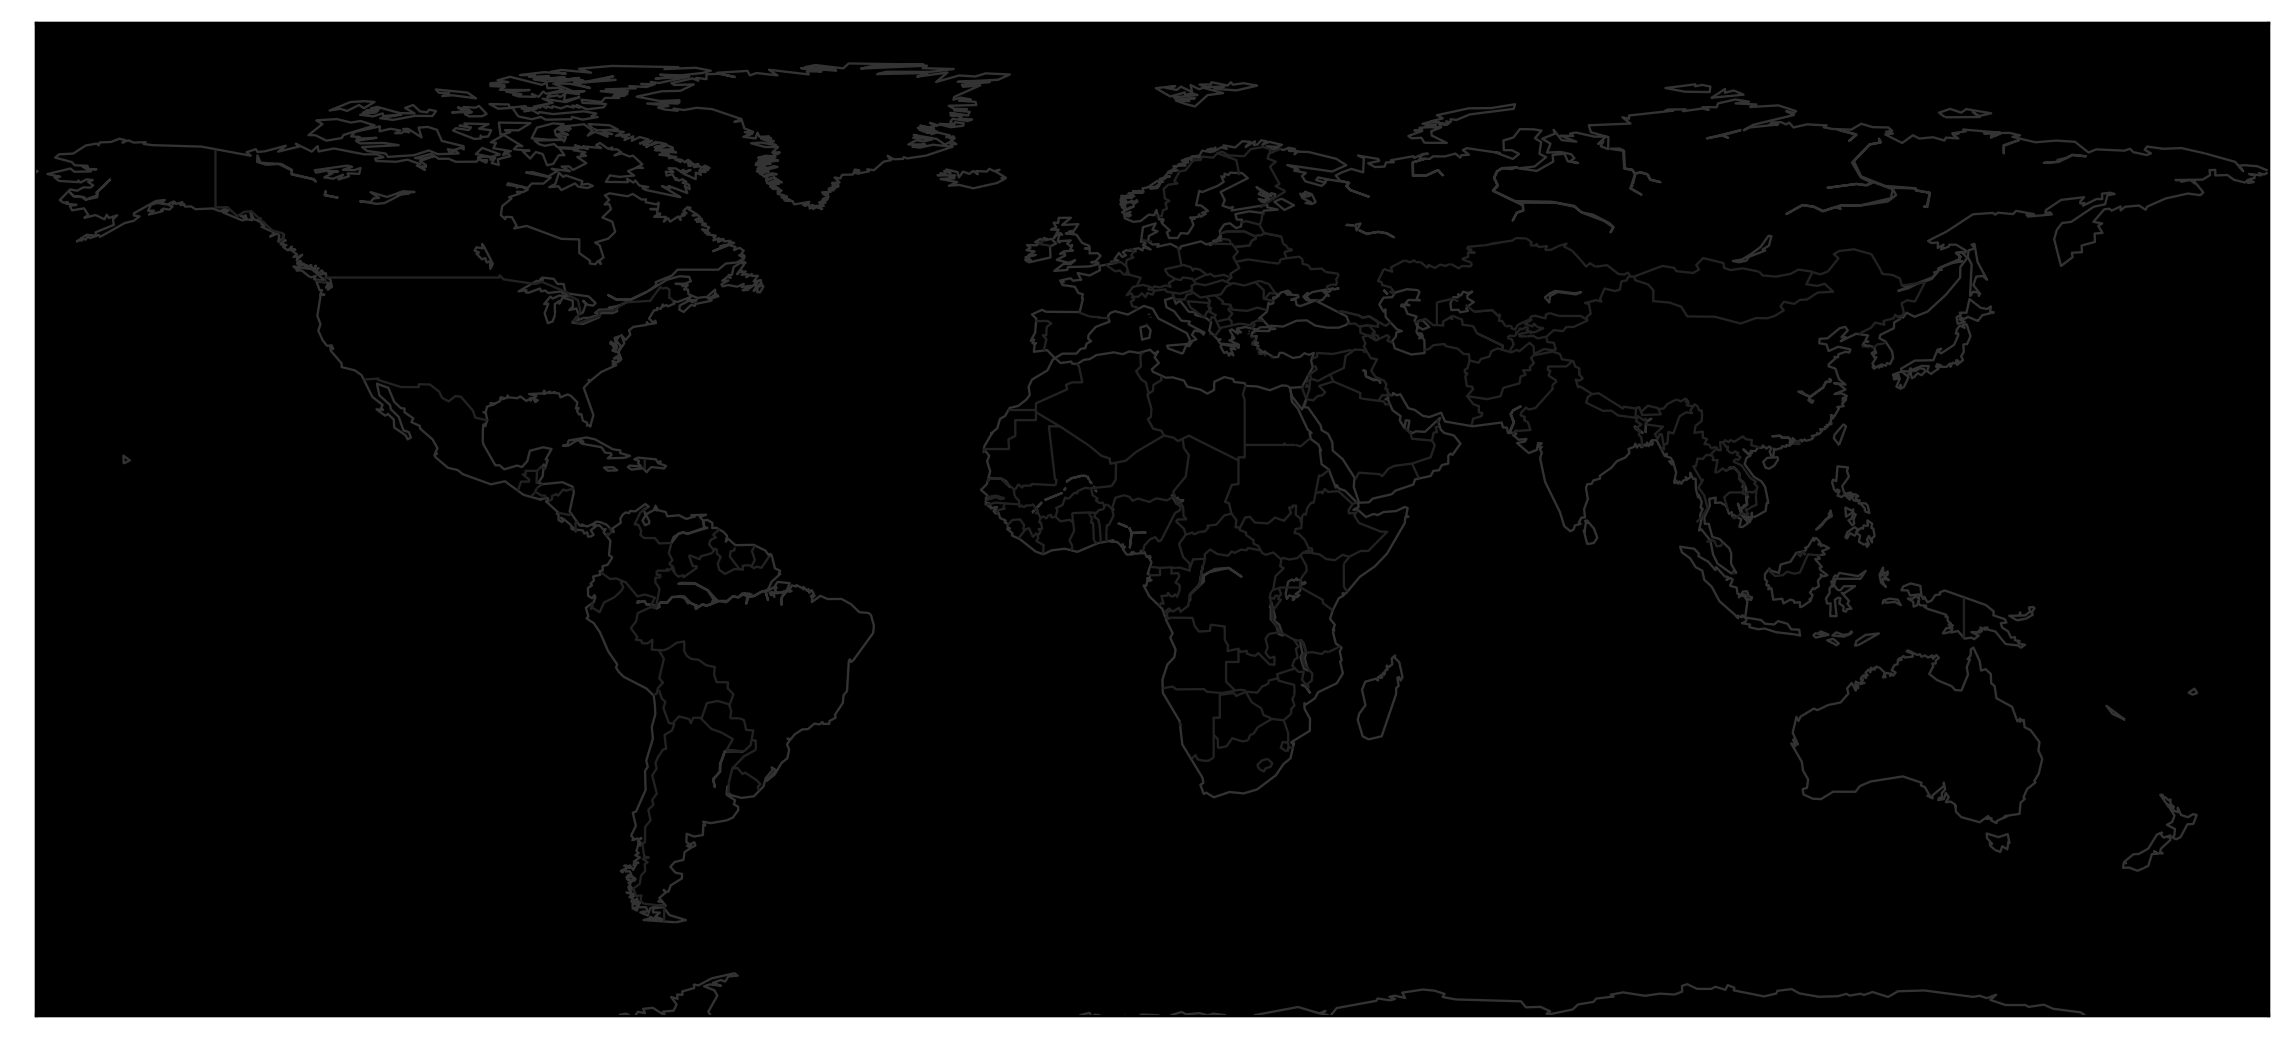

In [55]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

def get_base_fig():
    # Lets define some colors
    bg_color = "#000000"
    coast_color = "#333333"
    country_color = "#222222"
    fig = plt.figure(figsize=(12, 6))
    m = Basemap(projection='cyl', llcrnrlat=-70,urcrnrlat=90, 
                llcrnrlon=-170, urcrnrlon=190, area_thresh=10000.)
    m.fillcontinents(color=bg_color, lake_color=bg_color, zorder=-2)
    m.drawcoastlines(color=coast_color, linewidth=0.7, zorder=-1)
    m.drawcountries(color=country_color, linewidth=0.7, zorder=-1)
    m.drawmapboundary(fill_color=bg_color, zorder=-2)
    return fig, m

get_base_fig();

## Add each site

Instead of randomly assigning colours, I've tried to make the colour for each country somewhat related to the country itself. Normally via primary flag colour, although the fact most flags only use a very small subset of colours is quite difficult to work with.

Let's just get a snapshot for the final day in our dataset.

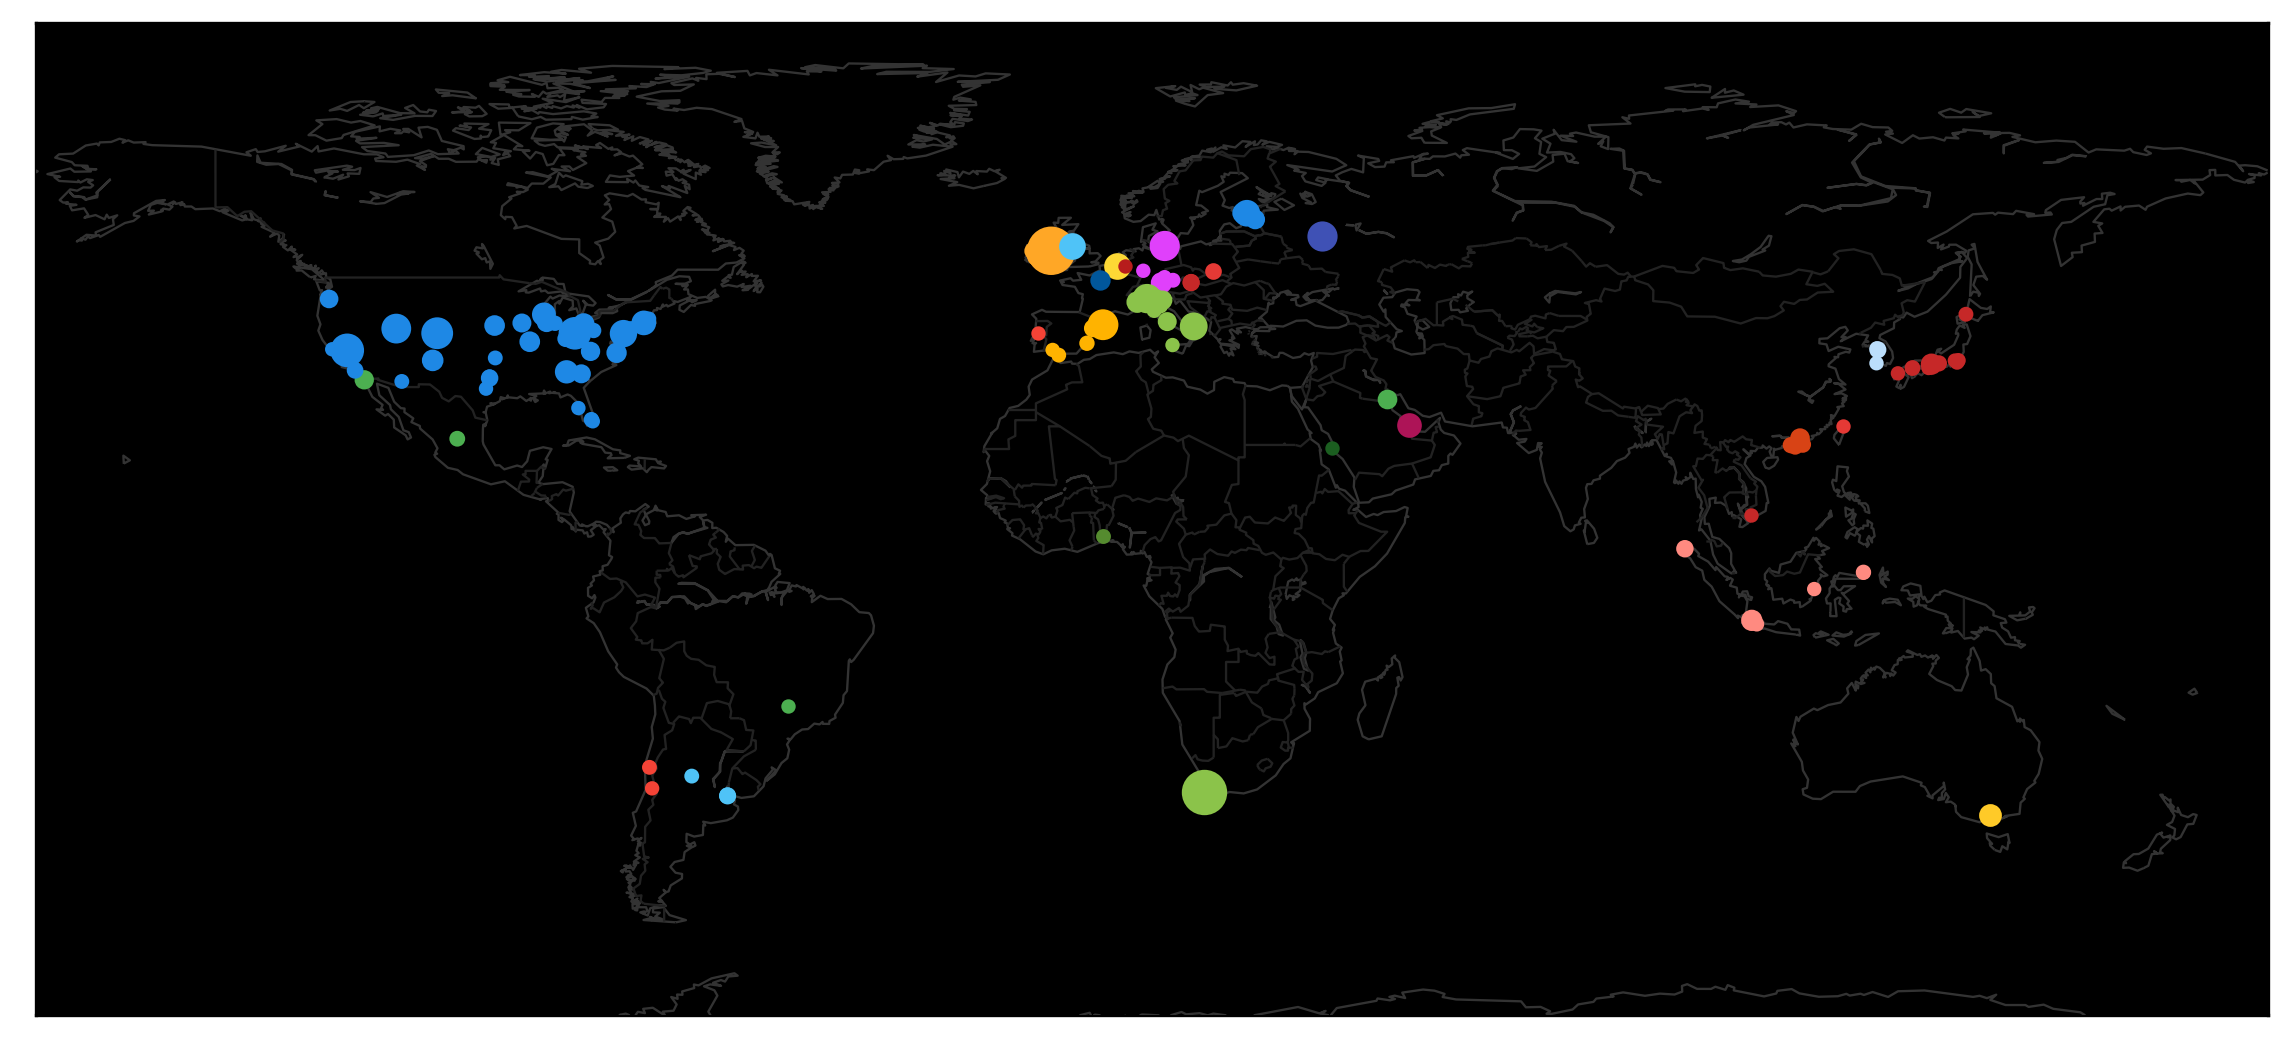

In [56]:
import numpy as np

# Colours based roughly on primary colour in countries flag
colors = {
    "Australia": "#FFD54F",
    "United States of America": "#1e88e5",
    "United Kingdom": "#4FC3F7",
    "Estonia": "#1E88E5",
    "Taiwan": "#E53935",
    "Vietnam": "#C62828",
    "Ireland": "#FFA726",
    "Brazil": "#4CAF50",
    "Argentina": "#4FC3F7",
    "Chile": "#F44336",
    "Indonesia": "#FF8A80",
    "Japan": "#C62828",
    "Germany": "#E040FB",
    "South Korea": "#BBDEFB",
    "Qatar": "#AD1457",
    "Poland": "#E53935",
    "Spain": "#FFB300",
    "Australia": "#FFCA28",
    "Russia": "#3F51B5",
    "Benin": "#558B2F",
    "Saudi Arabia": "#1B5E20",
    "Hong Kong": "#D84315",
    "France": "#01579B",
    "The Netherlands": "#B71C1C",
    "Belgium": "#FDD835",
    "Kuwait": "#4CAF50",
    "Yemen": "#D81B60",
    "Italy": "#8BC34A",
    "Austria": "#C62828",
    "Mexico": "#4CAF50",
    "Portugal": "#F44336",
    "South Africa": "#8BC34A",
}

def get_scatter(data):
    fig, m = get_base_fig()
    # Loop over each country and its institutions
    
    for country in np.unique(data.country):
        c = colors.get(country, "#FF99FF")
        subset = data.loc[(data.country == country) & (data.enrolment > 0), :]
        s = 10 + subset.enrolment
        m.scatter(subset.long, subset.lat, latlon=True, c=c, s=s, zorder=1)
    return m

get_scatter(test_row);

I mean... it's nice. But *cool* graphics glow and have changing colours. So I'll define a colormap that allows me to brighten the colour of each site when new patients come in, so that they flicker, glow and grow as they add patients into the system. 

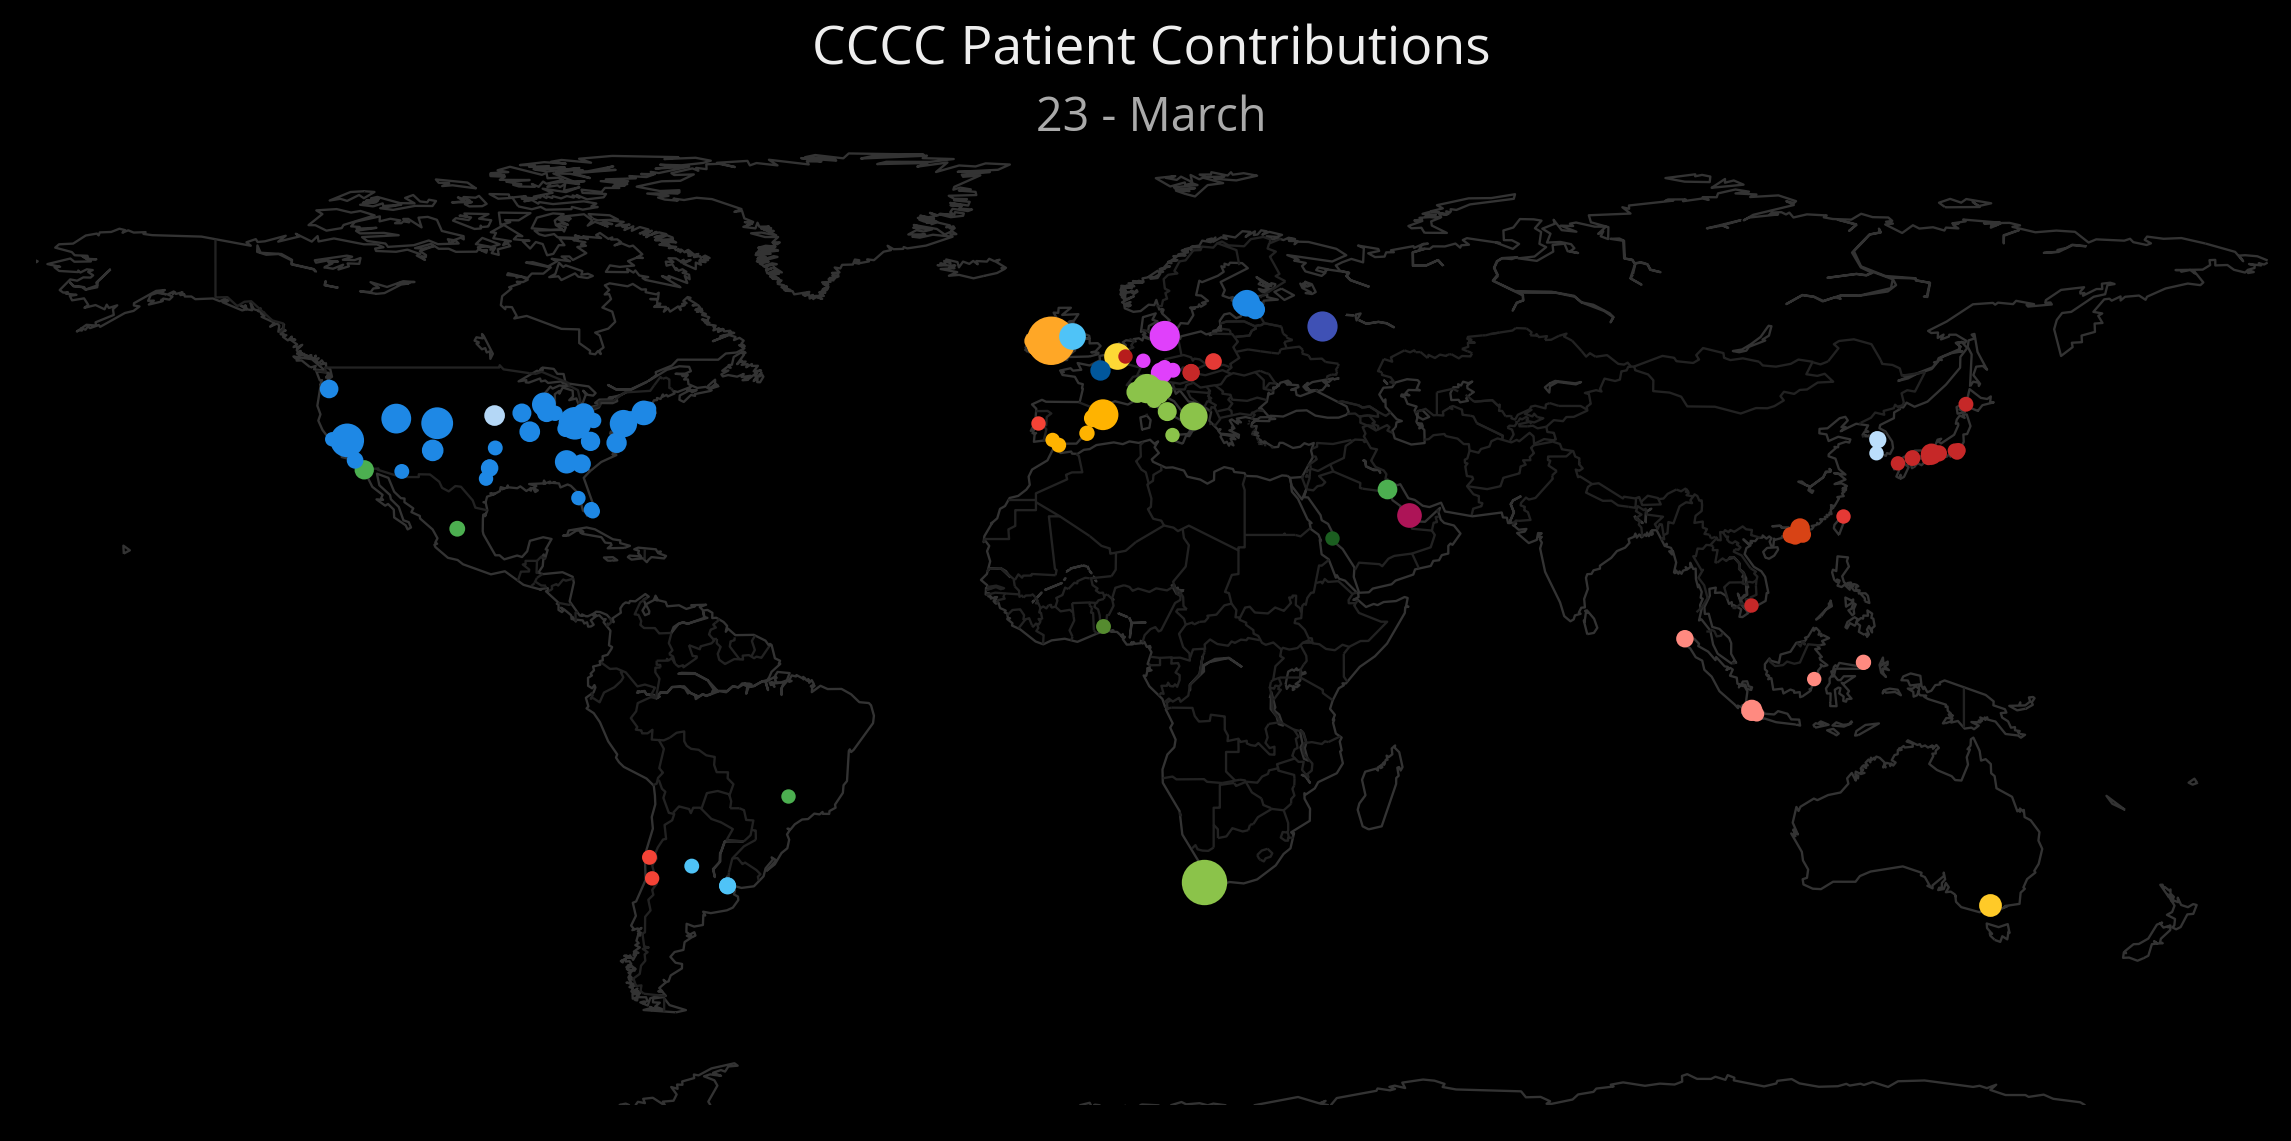

In [57]:
from matplotlib.colors import LinearSegmentedColormap as LSC

def get_shaded(data, date, frame=0, show=False):
    fig, m = get_base_fig()
    # Loop over each country and its institutions
    
    max_v = data.change.max() + 1
    
    for country in np.unique(data.country):
        c = colors.get(country)
        if c is None:
            c = "#FF99FF"
            print(f"Cannot find colour for country {country}")
        # From base colour, increase intensity of patients added today
        cmap = LSC.from_list("fade", [c, "#FFFFFF"], N=100)
        subset = data.loc[(data.country == country) & (data.enrolment > 0), :]
        s = 10 + subset.enrolment
        cs = cmap(2 * subset.change / max_v)
        m.scatter(subset.long, subset.lat, latlon=True, c=cs, s=s, zorder=1)
        
    # Set the title, and make the background black
    plt.title("CCCC Patient Contributions", fontsize=16, 
              color="#EEEEEE", fontname="Open Sans", y=1.03)
    d = pd.to_datetime(date).strftime("%d - %B")
    ax = fig.get_axes()[0]
    plt.text(0.5, 1.02, d, c="#AAAAAA", fontsize=14, 
             verticalalignment="top", horizontalalignment="center",
             transform=ax.transAxes)

    fig.patch.set_facecolor("#000000")
    if show:
        return fig
    else:
        name = f"cccc_enrolment/output/{frame:04d}.png"
        fig.savefig(name, bbox_inches="tight", padding=0, facecolor=fig.get_facecolor(), transparent=False, dpi=300)
        plt.close(fig)

get_shaded(test_row, "2020-03-23", show=True);

!!!main

Now let's test this whole thing animated, so lets loop over every row and output a frame that I'll stitch together using `ffmpeg`. Normally I'd use `joblib` for this... but `basemap` really doesn't like that.

In [ ]:
def plot_date(i, date):
    data = get_row(date)
    get_shaded(data, date, i)
    
for i, date in enumerate(data_fixed.index):
    plot_date(i, date)

Now that we have a bunch of frames, lets turn it into a ncie MP4 video. But lets be fancy, and have this bad boy glow. To do this, Im going to load in a mask (to make sure the title doesnt glow), and run it through a filter complex that took me 4 hours to debug until it worked. It will also add a few seconds of pause at the end, so on looping players people can still see the final result.

```
ffmpeg -r 30 -i cccc_enrolment/output/%04d.png -i cccc_enrolment/mask.png -filter_complex "      [1]setsar=sar=0[p],
[0]split[a][b],
[a][p]overlay,lumakey=0:tolerance=0.3:softness=0.3[x];
color=black,format=rgb24[c];
[c][x]scale2ref[c][i];
[c][i]overlay=format=auto:shortest=1,
setsar=sar=1,
gblur=30:3,
curves=all='0/0 0.5/0.9 1/0.9'[d],
[b]setsar=sar=1[e],
[d][e]blend=all_mode=addition,
scale=1920:-2,
tpad=stop_mode=clone:stop_duration=4
" -vcodec libx264 -crf 23 -movflags faststart -pix_fmt yuv420p cccc_enrolment/contributions.mp4
```

In [26]:
Video("cccc_enrolment/contributions.mp4")

And there it is! Perhaps soon I'll go through and manually add all the site names in, but for now, I feel this does a pretty good job of showing just how international our collaboration is.